##### import essential functions

In [1]:
# import some basic functions
import os
import re
import math
import glob
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# import functions for reading images
from Import_Functions import import_imgs

# import self_defined functions for segmentation based ALL
import seg_util as su
from skimage.measure import label
from scipy.ndimage import gaussian_filter

# import function for post-segmentation image process
# packages for visualizing images
import napari

import imageio
from skimage.measure import regionprops

##### core steps and code

- read images

In [2]:
# read image by import_img function or read image directly
# folder is the directory to the folder where your images are located
folder = r"C:\Users\Laga Ash\Desktop\project\nucleolus_segmentation_public\test_image\20220304_L1\10_2"
raw_img = import_imgs(folder,"Composite_stack.tif")
nucleus = import_imgs(folder,"nuclei_mask.tif")

- normalized raw image

In [3]:
# normalize images based on min-max normalization
normalized_img = np.stack([su.min_max_norm(raw_img[:,:,:,i]) for i in range(raw_img.shape[-1])],axis=3)

intensity normalization: min-max normalization with NO absoluteintensity upper bound
intensity normalization: min-max normalization with NO absoluteintensity upper bound
intensity normalization: min-max normalization with NO absoluteintensity upper bound



- use LPD-7 channel to segment and dilate the mask to create "nucleolar" mask

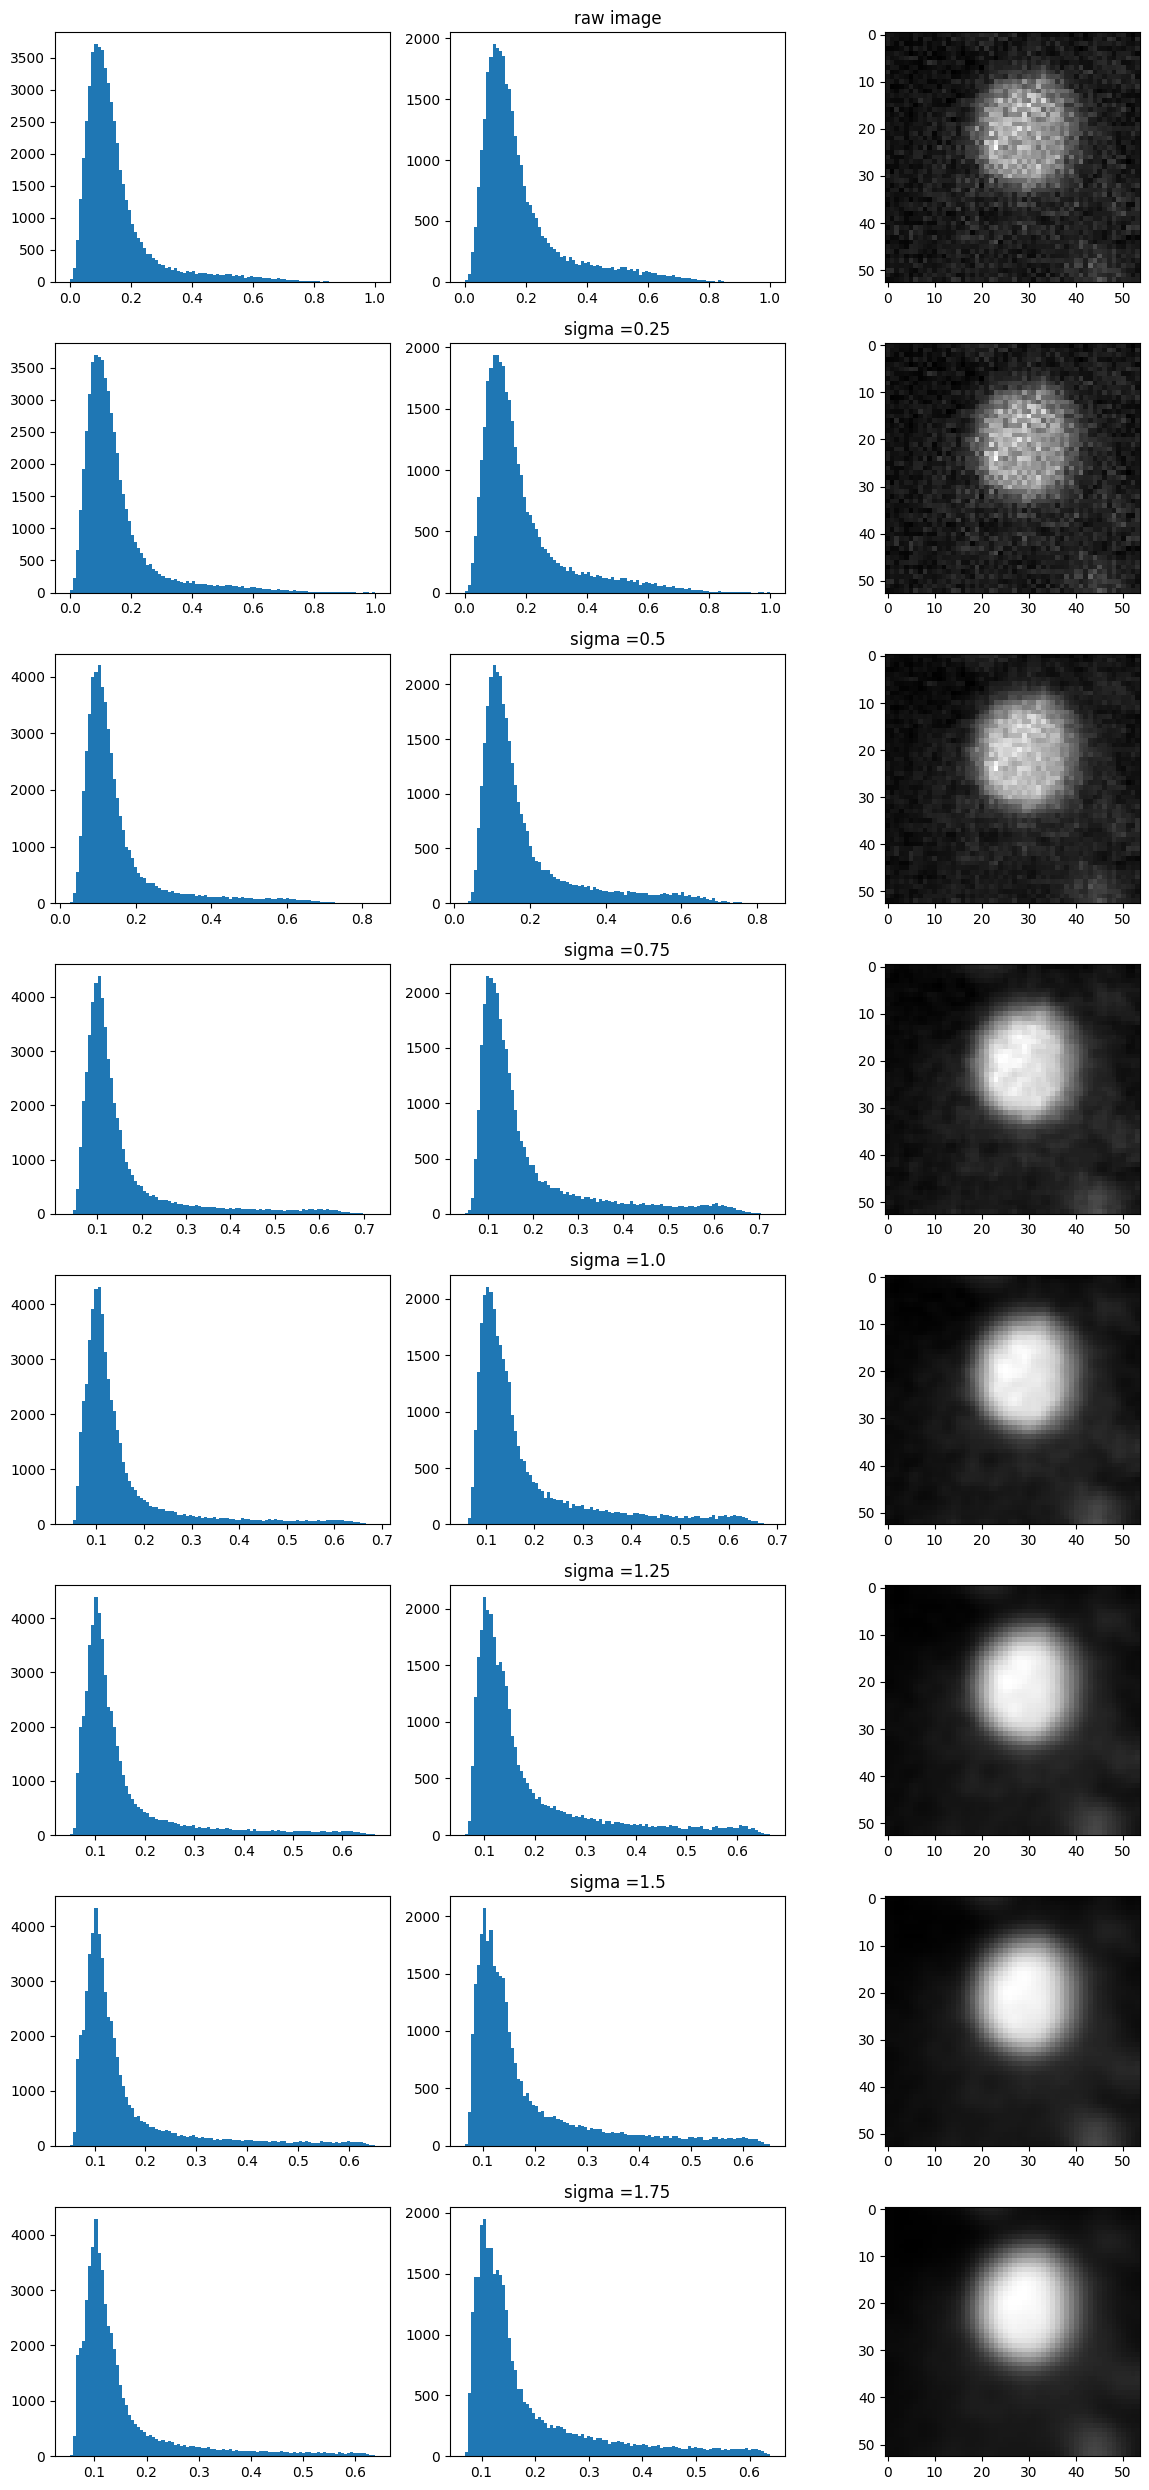

In [4]:
# plot intensity distribution to assess if one threshold is enough
# if bimodal distribution, can use single otsu
# assess with sigma value is good to preserve structure and reduce noise

sigmas = np.arange(0.25,2,0.25)
fig,axs = plt.subplots(len(sigmas)+1,3,figsize=(12,25))
mid_slice = int(0.5*normalized_img.shape[0])
# raw data
axs[0,0].hist(normalized_img[...,2].flatten(),bins=100)
axs[0,1].hist(normalized_img[...,2][nucleus>0].flatten(),bins=100)
axs[0,2].imshow(normalized_img[mid_slice,:,:,2],cmap="gray")
axs[0,1].set_title("raw image")
# smoothed image with different sigma
for i, sigma in enumerate(sigmas):
    GC_smoothed = gaussian_filter(normalized_img[...,2],sigma=sigma,mode="nearest",truncate=3)
    axs[i+1,0].hist(GC_smoothed.flatten(),bins=100)
    axs[i+1,1].hist(GC_smoothed[nucleus>0].flatten(),bins=100)
    axs[i+1,2].imshow(GC_smoothed[mid_slice,:,:],cmap="gray")
    axs[i+1,1].set_title("sigma ={}".format(sigma))
plt.tight_layout()

- sigma = 1 works best to preserve strcutral details and reduce noise

In [5]:
# 3d smooth raw LPD7 image
gc_smoothed_final = gaussian_filter(normalized_img[...,2],sigma=1,mode="nearest",truncate=3)

In [6]:
# otsu segment each channel as for ground and background
# adjust local_adjust parameter to make the segmentation more and less
gc_otsu = su.global_otsu(img=gc_smoothed_final,mask=nucleus,global_thresh_method="ave",mini_size=1200,local_adjust=1.1,extra_criteria=False,keep_largest=True)

otsu:0.34637200832366943,rouned otsu:0.35,ajusted otsu:0.385
number of mask is:  1
mask spot volumn 3143


In [7]:
viewer = napari.Viewer()
viewer.add_image(gc_smoothed_final,name="LPD-7",blending="additive",colormap="gray")
viewer.add_image(gc_otsu,name="LPD-7 seg",blending="additive",colormap="blue")
viewer.add_image(raw_img[...,1],name="RPOA-2",blending="additive",colormap="green")
viewer.add_image(raw_img[...,0],name="DAO-5",blending="additive",colormap="red")
napari.run()

In [ ]:
# # use white background black foreground to visualize
# view(seg_fluo_side_by_side(gc_otsu,raw_img[...,2]))
# view(segmentation_quick_view(gc_otsu))
# view(single_fluorescent_view(raw_img[...,2]))

- segment holes in GC using LoG
    - LoG_sigma value based on the estimation of holes size, sigma ~= 0.3*hole diameter
    - choose LoG sigma range based on representative images
    - change LoG_sigma parameter to make the segmentation more and less

In [ ]:
# guassian laplace edge detecting dark spots
gc_dark_spot = su.segment_spot(normalized_img[...,2],nucleus,gc_otsu,LoG_sigma=list(np.arange(2.5,5,0.25,dtype=float)),mini_size=30,invert_raw=True)

In [28]:
final_gc, hole_filled = su.final_gc_holes(gc_dark_spot,gc_otsu)

In [30]:
# save image 
# method 1:
# imageio.volwrite ("directory to folder\gc.tif",final_gc)
# method 2:
# OmeTiffWriter.save(final_gc,r"directory to folder\gc.tif",dim_order="ZYX")

In [ ]:
mid_slice = int(0.5*normalized_img.shape[0])
fig,axs = plt.subplots(1,4,figsize=(16,10))
axs[0].imshow(gc_otsu[mid_slice,:,:],cmap="gray")
axs[1].imshow(final_gc[mid_slice,:,:],cmap="gray")
axs[2].imshow(gc_dark_spot[mid_slice,...],cmap="gray")
axs[3].imshow(normalized_img[mid_slice,:,:,2],cmap="gray")
axs[0].set_title("gc otsu")
axs[1].set_title("after size thresholding") 
axs[2].set_title("holes")



In [ ]:
# use white background black foreground to visualize
#view(seg_fluo_side_by_side(raw_img[...,2],holes))

##### batch process

In [ ]:
main_folder = r"directory to the test image folder"
image_name = "Composite_stack.tif"
nucleus_mask_name = "nuclei_mask.tif"
background_mask_name = "background_mask.tif"

for item in os.listdir(main_folder):
    experiment_set_dir = os.path.join(main_folder,item)

    if os.path.isdir(experiment_set_dir):
        cells = os.listdir(experiment_set_dir)
        for cell in cells:
            cell_dir = os.path.join(experiment_set_dir,cell)
            # read the images
            raw_img = import_imgs(cell_dir, image_name)
            nucleus_mask = import_imgs(cell_dir, nucleus_mask_name)
            background_mask = import_imgs(cell_dir, background_mask_name)

            gc_mask, holes, hole_filled = su.gc_segment(raw_img, nucleus_mask, background_mask, sigma=1, local_adjust_for_GC=1.08)

            # save files
            imageio.volwrite (os.path.join(cell_dir,"gc.tif"),gc_mask)
            imageio.volwrite (os.path.join(cell_dir,"holes.tif"),holes)
            imageio.volwrite (os.path.join(cell_dir,"hole_filled.tif"),hole_filled)
            # if imageio does not work use 
            # OmeTiffWriter.save(gc_mask,os.path.join(cell_dir,"gc.tif"),dim_order="ZYX")
            # OmeTiffWriter.save(holes,os.path.join(cell_dir,"holes.tif"),dim_order="ZYX")
            # OmeTiffWriter.save(hole_filled,os.path.join(cell_dir,"hole_filled.tif"),dim_order="ZYX")
            
            # check if GC mask is segmented, if not, check the individual cell
            if np.count_nonzero(gc_mask) > 0:
                print("GC mask is segmented")
            else:
                print("GC mask is not segmented")
                print(cell_dir)